# Filter study for Cryoscope

**Goal**: testing filter application similarly to what I am supposed to do with FIR

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import special
from scipy.optimize import least_squares
from IIR import step, residuals_inverse_IIR, inverse_model_IIR
from tools import Signal, plot_signal_filtered, plot_reconstructed_data

from qibocal.protocols.two_qubit_interaction.cryoscope import _fit, _plot, CryoscopeData, CryoscopeType 

FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(50), np.zeros(10)])


[Qibo 0.2.12|INFO|2024-12-16 18:09:04]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-16 18:09:04]: Loading platform dummy


**Loading data**

In [2]:
with open('savgol_data.pkl', 'rb') as file:
    data_phase = pickle.load(file)
    savgol_demod = data_phase["savgol_demod"]
    savgol_no_demod = data_phase["savgol_no_demod"]
    no_savgol_demod = data_phase["no_savgol_demod"]
    no_savgol_no_demod = data_phase["no_savgol_no_demod"]

with open('CryoscopeResults.pkl', 'rb') as file:
    data_results = pickle.load(file)
    result_svg_dem = data_results["savgol_demod"]
    result_svg_no_dem = data_results["savgol_no_demod"]
    result_no_svg_dem = data_results["no_savgol_demod"]
    result_no_svg_no_dem = data_results["no_savgol_no_demod"]

#### Reproduce rectangular impulse response

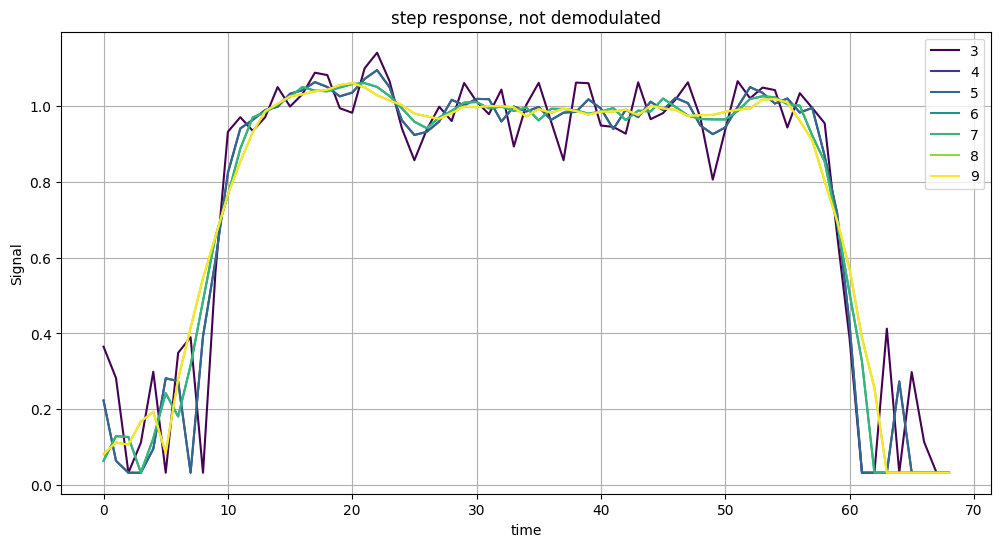

In [3]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6)) 

for i, res in enumerate(result_svg_no_dem):
    plt.plot(res.step_response["D1"], color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("step response, not demodulated")
plt.legend()
plt.grid()
plt.show()

## Minimization on step

In [4]:
initial_guess = [1, 1, 1]
t = np.arange(0,30,1)
start = 10
step_response = result_svg_no_dem[4].step_response["D1"][0:30]
print(len(step_response))

30


In [5]:
result = least_squares(residuals_inverse_IIR, initial_guess, args=(t, start, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-4.717e-26 -2.827e-23 ... -2.011e-02  1.537e-03]
           x: [ 1.008e+00  1.755e-01 -2.418e-01]
        cost: 0.018943915785561153
         jac: [[ 4.680e-26 -1.531e-23 -1.950e-25]
               [ 2.806e-23 -8.261e-21 -1.169e-22]
               ...
               [-9.724e-01  0.000e+00 -0.000e+00]
               [-9.939e-01  0.000e+00 -0.000e+00]]
        grad: [ 1.003e-09  8.490e-08 -3.189e-07]
  optimality: 3.189443486096384e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 14
        njev: 11


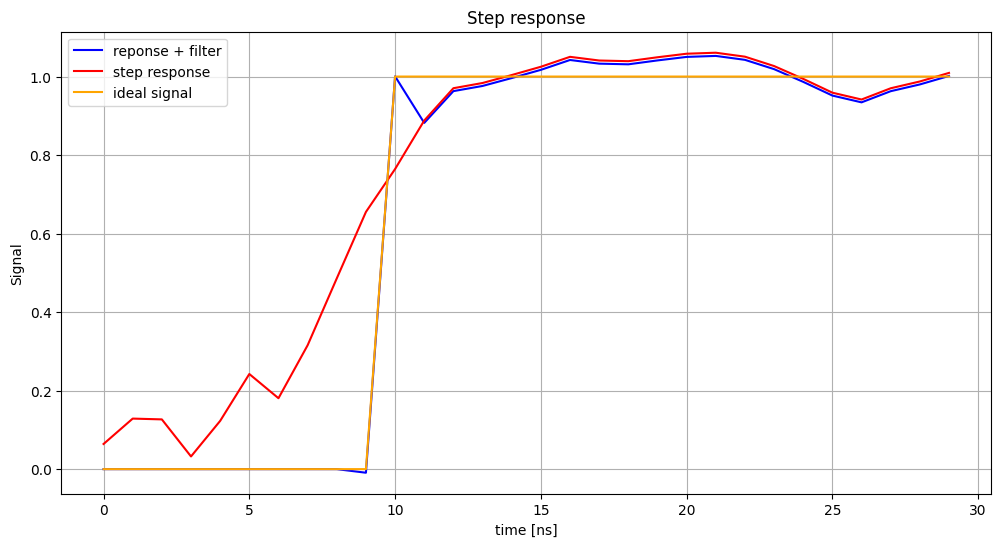

In [6]:
filtered_response = Signal(
    inverse_model_IIR(result.x, t, start, step_response),
    label="reponse + filter")

response = Signal(
    step_response,
    label="step response"
)

plot_signal_filtered(filtered_response, response, t, start)

In [7]:
init_guess = [1,1,1]
results = []
responses = []

for i in range(5):
    result = least_squares(
        residuals_inverse_IIR, initial_guess, args=(t, start, step_response)
    )  # calcolo LSO
    results.append(result) 
    step_response = inverse_model_IIR(result.x, t, start, step_response)
    responses.append(step_response) 

/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:21: RuntimeWarning: overflow encountered in exp
  return data / (g * (1 + A * np.exp(-(t - start) / tau)))


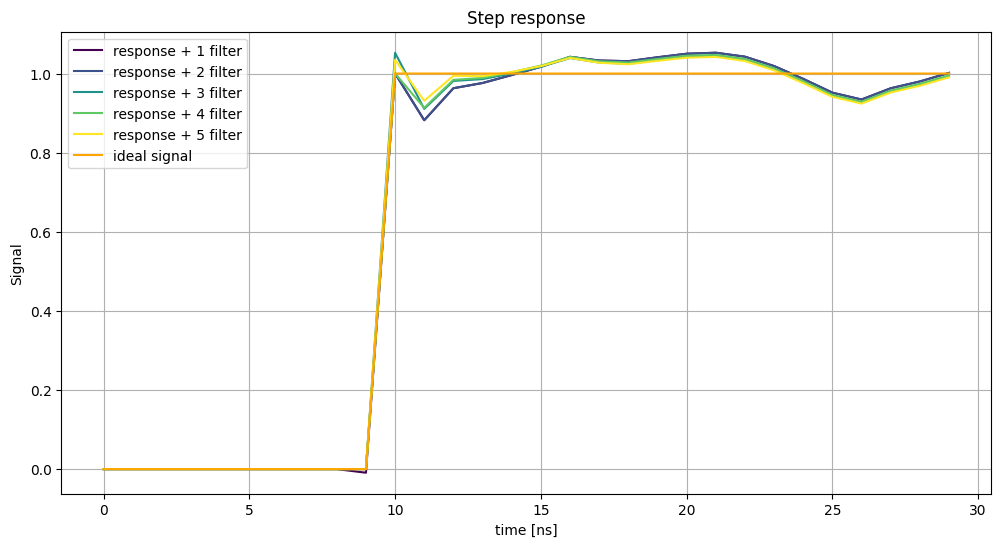

In [9]:
step_response = result_svg_no_dem[4].step_response["D1"][10:40]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

## Minimization on constant signal

**Risposta sollo sull'intervallo 10 - 40**

Provo ad applicare il modello (e ottimizzarlo) sulla risposta a partire dall'invio di un segnale non nullo.

NB: devo ridefinire modello e filtro perchè l'esponenziale non sia traslato, devo ridefinire anche il segnale ideal perchè in questo caso la step function è semplicemente un vettore oneslike

In [10]:
initial_guess = [1, 1, 1]
t = np.arange(0, 30, 1)
start = 0
step_response = result_svg_no_dem[4].step_response["D1"][10:40]
print(len(step_response))

30


In [11]:
result = least_squares(residuals_inverse_IIR, initial_guess, args=(t, start, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.879e-03 -1.545e-02 ... -1.883e-02 -2.777e-02]
           x: [ 1.008e+00  1.184e+00 -2.444e-01]
        cost: 0.013525619800523426
         jac: [[-9.961e-01  0.000e+00 -1.329e+00]
               [-9.769e-01  8.244e-02 -4.727e-01]
               ...
               [-9.736e-01  0.000e+00 -0.000e+00]
               [-9.647e-01  0.000e+00 -0.000e+00]]
        grad: [-1.036e-09 -3.966e-07 -1.431e-07]
  optimality: 3.965798406411602e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 9
        njev: 8


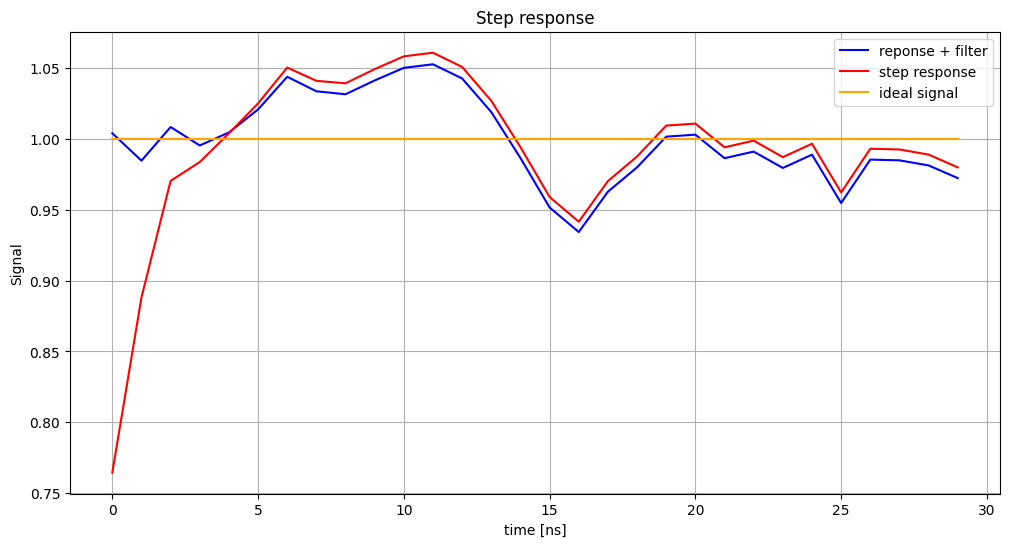

In [12]:
filtered_response = Signal(
    inverse_model_IIR(result.x, t, start, step_response), label="reponse + filter"
)

response = Signal(step_response, label="step response")

plot_signal_filtered(filtered_response, response, t, start)

Applicazione iterativa del filtro

In [14]:
init_guess = [1,1,1]
results = []
responses = []

for i in range(5):
    result = least_squares(residuals_inverse_IIR, initial_guess, args=(t, start, step_response)) #calcolo LSO
    results.append(result) 
    step_response = inverse_model_IIR(result.x, t, start, step_response)
    responses.append(step_response)

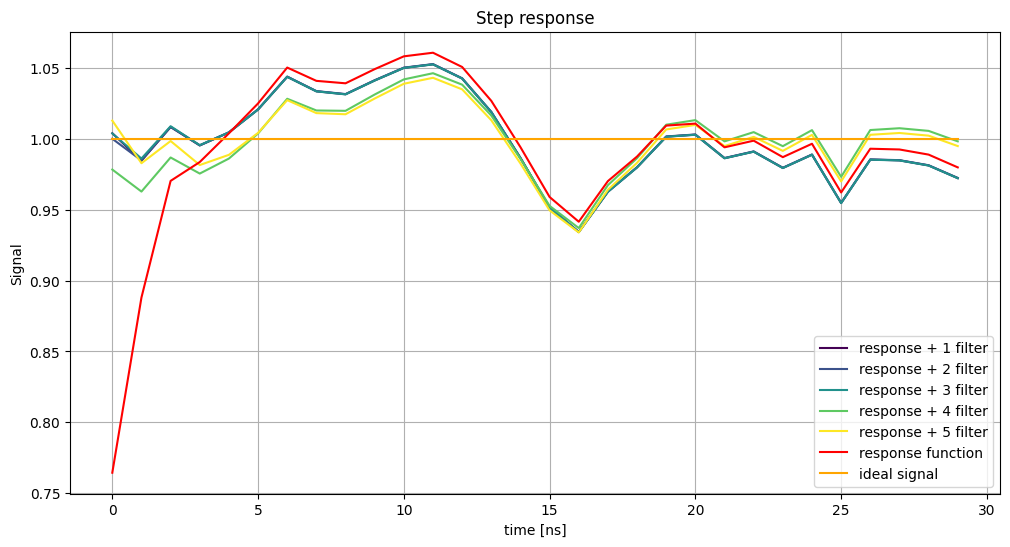

In [15]:
step_response = result_svg_no_dem[4].step_response["D1"][10:40]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()